# Cifar 10 

## Setup

### Imports

In [1]:
from functools import reduce

import numpy as np
import plotly.io as pio
from numpy import ndarray
import plotly.express as px
from numpy import array_split as split

from optimizers import Adam
from metrics import accuracy
from constants import MAX_NB_SAMPLES
from losses import BinaryCrossentropy
from cifar_10_dataset_loading import load_cifar_10
from layers import Convolutional, Linear, Relu, BatchNorm, Flatten, Softmax, MaxPool, Layer, LeakyRelu

In [2]:
pio.renderers.default = "jupyterlab+png"

### Data extraction

In [3]:
x_train, y_train, x_test, y_test = load_cifar_10()

In [4]:
classes = y_train.argmax(axis=1)

In [5]:
# Change range from [0, 255] to [-1, 1]
x_train = x_train / 255  
x_train.dtype

dtype('float64')

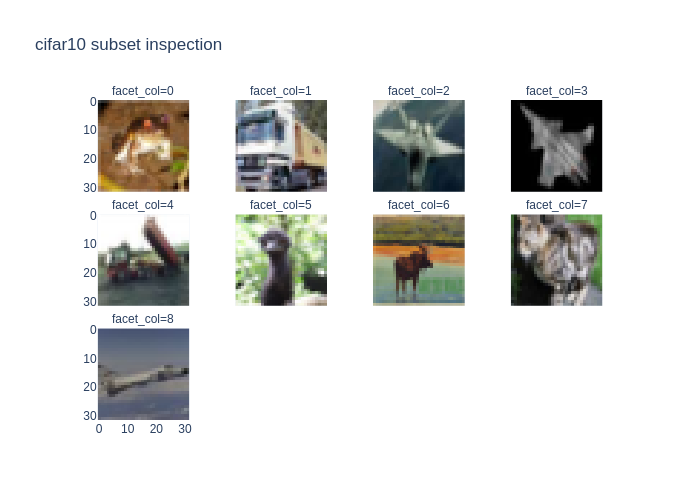

In [6]:
IMGS_IDX = [0, 1, 5673, 5494, 2, 55, 66, 776, 564]
x = x_train[IMGS_IDX]
y = y_train[IMGS_IDX]
px.imshow(x, facet_col=0, facet_col_wrap=4, title="cifar10 subset inspection")

In [7]:
NB_SAMPLES_PER_CLASS = 1000
NB_CLASSES = 10

class_masks = y_train.argmax(1, keepdims=True) == np.arange(NB_CLASSES)
take_first_n_of_class = lambda data, class_idx: data[class_masks[:, class_idx]][:NB_SAMPLES_PER_CLASS]
take_first_n_of_each_class = lambda data: np.concatenate([take_first_n_of_class(data, class_idx) for class_idx in range(NB_CLASSES)], axis=0)
x_train_subset = take_first_n_of_each_class(x_train)
y_train_subset = take_first_n_of_each_class(y_train)
x_train_subset.shape

(10000, 32, 32, 3)

## Fitting cifar10

### Model declaration

In [8]:
def create_nn() -> list[Layer]:
    return [
        Convolutional((10, 7, 7, 3)),
        BatchNorm(),
        Relu(),
        MaxPool((2, 2)),
        Flatten(),
        Linear(1690, 300),
        LeakyRelu(),
        Linear(300, y.shape[1]),
        Softmax(),
    ]

### Optimizer

In [9]:
def create_optimizer(nn:list[Layer]) -> Adam:
    return Adam(
        nn,
        x_train,
        y_train,
        BinaryCrossentropy(),
        starting_lr=0.015,
        lr_decay=0.0001,
        momentum_weight=0.8,
        ada_grad_weight=0.999,
        l2_weight=0.0,
    )

In [10]:
NB_TEST_BATCHES = int(np.ceil(len(x_test) / MAX_NB_SAMPLES))
loss = BinaryCrossentropy()

def test_accuracy(metric_line:dict, nn:list[Layer], **_) -> dict:
    y_test_pred = []
    for x_test_subset in split(x_test, NB_TEST_BATCHES):
        y_test_pred.append(reduce(lambda x, l: l.forward(x), nn, x_test_subset))
    y_test_pred = np.concatenate(y_test_pred)
    metric_line["test_accuracy"] =  np.mean(y_test_pred.argmax(1) == y_test.argmax(1))
    metric_line["test_loss"] = loss.forward(y_test_pred, y_test)
    return metric_line


### Training

In [11]:
nn = create_nn()
first_optimizer = create_optimizer(nn)

In [12]:
bad_training_stats = (
    first_optimizer
    .optimize_nn(
        epochs=35,
        batch_size=500,
        metrics=[accuracy, test_accuracy],
        height=600,
    )
)

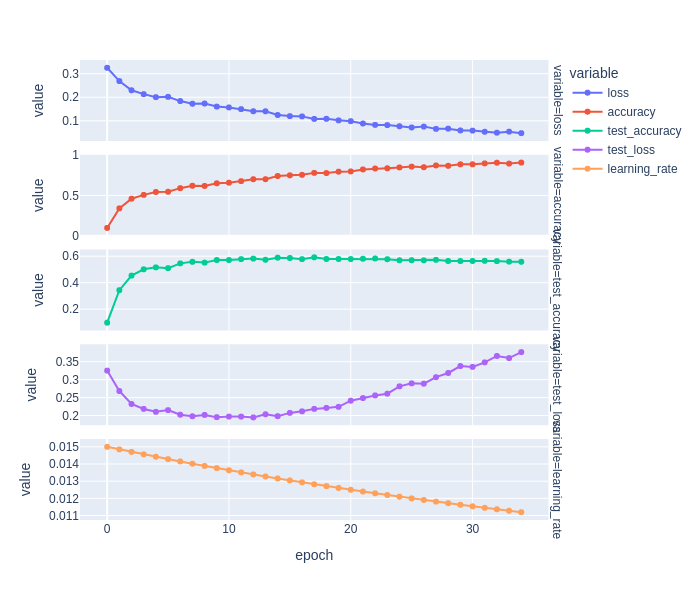

In [13]:
px.line(
    bad_training_stats.melt("epoch", ["loss",
            "accuracy",
            "test_accuracy",
            "test_loss",
            "learning_rate",
        ]),
    x="epoch",
    y="value",
    facet_row="variable",
    color="variable",
    markers=True,
    height=600,
).update_yaxes(matches=None)

Looking at the training stats, we can see that the model started overfitting on the training dataset at epoch ~14.  
This means that we would probably need to add a data augmentation technique and some regulirazation.

In [14]:
test_accuracy({}, nn)

{'test_accuracy': np.float64(0.56),
 'test_loss': np.float64(0.3861144762963465)}

## Inspecting the trained model

Let's peak an image to view the activations through the network.

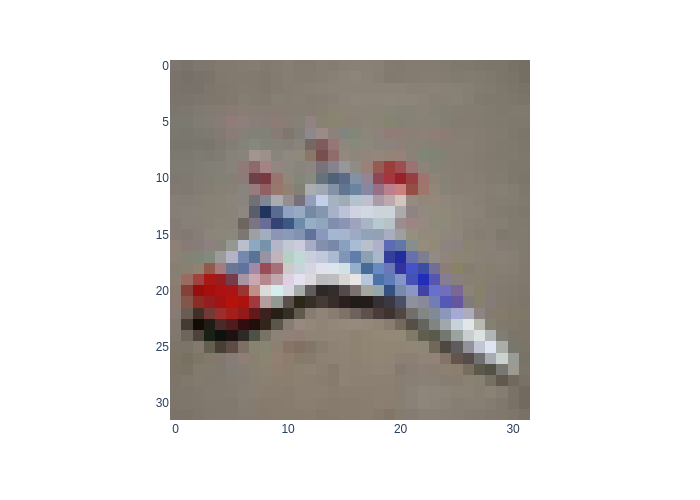

In [15]:
TARGET_IMG = 30
px.imshow(x_train[TARGET_IMG])

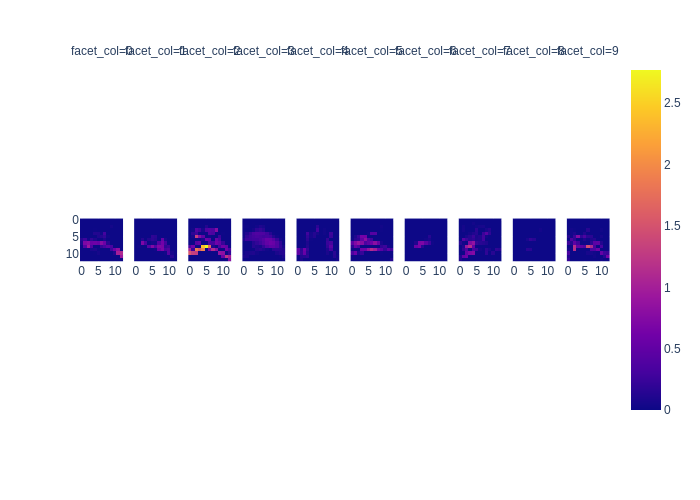

In [16]:
imgs = x_train[:1000]
convs =  reduce(lambda x, l: l.forward(x), nn[:4], imgs) #nn[1].forward(nn[0].forward(img))
convs.shape
px.imshow(convs[TARGET_IMG], facet_col=2, facet_col_wrap=10)

In [17]:
convs.sum(axis=(0, 1, 2))

array([15048.33560038, 14666.10817639, 29416.26412636, 20955.22428276,
       19559.16124418, 13819.26604813,  8322.62953316, 20057.92254003,
        8735.62854146, 28443.67596118])

In [18]:
activations = reduce(lambda x, l: l.forward(x), nn[:7], imgs) #nn[1].forward(nn[0].forward(img))
activations.sum(axis=(0))

array([-1.68286973e+02, -1.96650461e+02, -2.06744722e+02, -3.54501401e+01,
       -2.15018025e+02, -8.61722670e+01, -4.61239120e+01, -1.51640548e+02,
       -3.44775217e+01, -9.96202505e+01, -4.28206598e+02, -1.13372032e+02,
       -4.22994703e+01, -2.25407365e+02,  1.88653629e+02, -8.93955748e+01,
        5.95113422e+02, -2.74071048e+02, -2.73151997e+02,  1.06261848e+03,
       -3.03181540e+02,  4.72682274e+02, -1.23636758e+02, -2.64143650e+02,
       -2.74153809e+01, -2.85795753e+02, -7.84506447e+01, -4.55319610e+01,
        1.66153501e+03, -1.28374320e+02, -3.98886030e+01, -9.52546860e+01,
       -1.19186705e+02, -3.70614725e+02, -2.33280781e+02, -3.00743118e+02,
       -3.25388300e+01, -5.64229280e+01, -2.49335290e+02, -3.87628907e+01,
       -2.61578474e+02, -7.26005753e+01, -2.20334458e+02, -3.31473107e+02,
       -8.95064550e+01, -2.81735367e+01, -2.23058362e+02, -1.40285224e+02,
        5.93020873e+02, -8.75559540e+01, -1.14099612e+02, -2.77228066e+02,
       -3.43608020e+01, -

In [19]:
convs[[250]].shape

(1, 13, 13, 10)

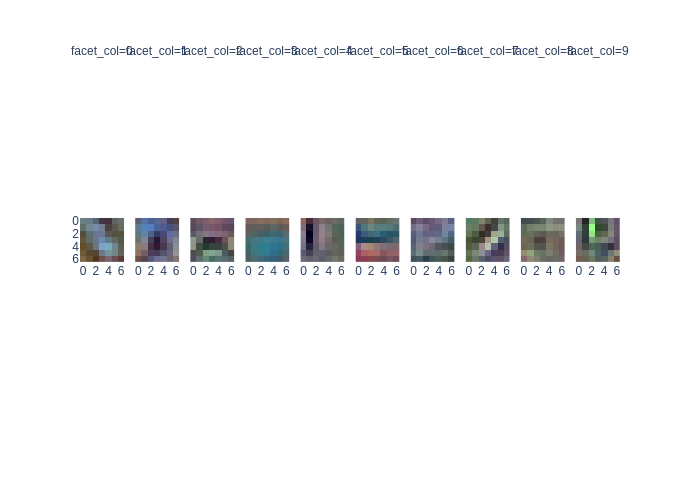

In [20]:
def min_max_normalize(arr:np.ndarray, axis:tuple) -> np.ndarray:
    return (arr - arr.min(axis, keepdims=True)) / (arr.max(axis, keepdims=True) - arr.min(axis, keepdims=True))

MIN = nn[0].kernels.min()
MAX = nn[0].kernels.max()
normed_kernels = (nn[0].kernels - MIN) / (MAX - MIN)
normed_kernels.shape

px.imshow(normed_kernels, facet_col=0, facet_col_wrap=10)

In [21]:
nn[0].biases

array([[[[ 8.42639485e-12, -1.75344698e-11,  2.48404878e-11,
           3.83153923e-11,  2.16357063e-12, -3.00830674e-11,
          -6.22100131e-12,  1.18847556e-11, -5.10125637e-11,
          -7.37448126e-12]]]])

In [22]:
nn[1].gamma

array([[[[0.38608128, 0.66709622, 0.56305379, 0.25400912, 0.41576247,
          0.42090398, 0.68163719, 0.33882058, 0.60693249, 0.38165039]]]])

In [23]:
nn[1].beta

array([[[[-0.2947325 , -0.72720792, -0.37745905,  0.02124765,
          -0.26840579, -0.36625753, -0.94605281, -0.16557258,
          -0.74552249, -0.17921048]]]])

## Conclusion
